In [29]:
# Data directory /Users/scott/p5/data/interim/n35_train_valid_test

In [30]:
import numpy as np
import pandas as pd
import keras
from keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg19 import decode_predictions
from keras.models import Sequential, Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from glob import glob
import os.path
import PIL
import cv2
import re
from collections import defaultdict, namedtuple

from PIL import Image
from io import BytesIO
from IPython.display import HTML

In [31]:
pd.set_option('display.max_colwidth', -1)

def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
def get_classes(path):
    directories = glob(os.path.expanduser(path) + '/*')
    return [dir.split('/')[-1] for dir in directories]
n_classes =  len(get_classes('/Users/scott/p5/data/interim/n35_train_valid_test/train'))
n_classes

3

In [4]:
def to_gray_scale(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.cvtColor(image,cv2.COLOR_GRAY2BGR)
    return np.array(gray_image)

In [37]:
def gray_and_scale(image):
    return cv2.resize(to_gray_scale(image), (224, 224))

In [98]:
def get_heat_value(img_segment, model, labels):
    resized_and_grayscaled_image = cv2.resize(to_gray_scale(img_segment), (224, 224))
    pred_array = model.predict(np.expand_dims(resized_and_grayscaled_image, axis=0))
    if labels[np.argmax(pred_array)] == 'N35':
        return 1
    elif labels[np.argmax(pred_array)] == 'N35_part':
        return 0.5
    else:
        return 0
    
get_heat_value(img_part, model, labels)

0.5

In [5]:
 vgg19 = keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224,224, 3))

In [6]:
# note we exclude the final dense layers and add one back below, we would retrain it ourselves
base_model = vgg19
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False 
    
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
predictions = Dense(n_classes, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [8]:
train_path = os.path.expanduser('/Users/scott/p5/data/interim/n35_train_valid_test/train')
test_path = os.path.expanduser('/Users/scott/p5/data/interim/n35_train_valid_test/test')
valid_path = os.path.expanduser('/Users/scott/p5/data/interim/n35_train_valid_test/valid')

In [9]:
train_batches = ImageDataGenerator(preprocessing_function=to_gray_scale).flow_from_directory(train_path,
                                                         target_size=(224,224), 
                                                         batch_size=6)
valid_batches = ImageDataGenerator(preprocessing_function=to_gray_scale).flow_from_directory(valid_path, 
                                                         target_size=(224,224), 
                                                         batch_size=5)
test_batches = ImageDataGenerator(preprocessing_function=to_gray_scale).flow_from_directory(test_path, 
                                                        target_size=(224,224),
                                                        shuffle=False,
                                                        batch_size=1)


Found 735 images belonging to 3 classes.
Found 158 images belonging to 3 classes.
Found 158 images belonging to 3 classes.


In [10]:
# sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(Adam(lr=0.00002), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(Adam(lr=0.00002), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# patient early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
# mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
hist = model.fit_generator(train_batches, 
                    steps_per_epoch=4, 
                    validation_data=valid_batches, 
                    validation_steps=4,
                    epochs=100,
                    verbose=2)#, 
#                     callbacks=[es, mc])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
 - 18s - loss: 5.4548 - acc: 0.3333 - val_loss: 5.0242 - val_acc: 0.4500
Epoch 2/100
 - 17s - loss: 4.6299 - acc: 0.3750 - val_loss: 3.0649 - val_acc: 0.5000
Epoch 3/100
 - 17s - loss: 4.5564 - acc: 0.3333 - val_loss: 4.1576 - val_acc: 0.4500
Epoch 4/100
 - 17s - loss: 3.6904 - acc: 0.5417 - val_loss: 3.6422 - val_acc: 0.4000
Epoch 5/100
 - 17s - loss: 2.4489 - acc: 0.5417 - val_loss: 3.3507 - val_acc: 0.4500
Epoch 6/100
 - 17s - loss: 4.9762 - acc: 0.2917 - val_loss: 2.1961 - val_acc: 0.5000
Epoch 7/100
 - 17s - loss: 4.8867 - acc: 0.5000 - val_loss: 2.4890 - val_acc: 0.4500
Epoch 8/100
 - 16s - loss: 4.2516 - acc: 0.4583 - val_loss: 4.5059 - val_acc: 0.2222
Epoch 9/100
 - 17s - loss: 5.5829 - acc: 0.3333 - val_loss: 4.0110 - val_acc: 0.2000
Epoch 10/100
 - 17s - loss: 4.4581 - acc: 0.3333 - val_loss: 2.7944 - val_acc: 0.4500
Epoch 11/100
 - 18s - loss: 3.3385 - acc: 0.4167 - va

Epoch 88/100
 - 17s - loss: 0.2231 - acc: 0.9583 - val_loss: 0.4852 - val_acc: 0.8333
Epoch 89/100
 - 17s - loss: 0.4893 - acc: 0.8750 - val_loss: 0.6329 - val_acc: 0.9000
Epoch 90/100
 - 18s - loss: 0.3892 - acc: 0.8333 - val_loss: 0.3015 - val_acc: 0.9000
Epoch 91/100
 - 16s - loss: 0.5751 - acc: 0.8333 - val_loss: 0.1783 - val_acc: 0.9000
Epoch 92/100
 - 17s - loss: 0.1720 - acc: 0.9583 - val_loss: 1.1401 - val_acc: 0.8500
Epoch 93/100
 - 17s - loss: 1.1971 - acc: 0.7952 - val_loss: 0.2845 - val_acc: 0.9000
Epoch 94/100
 - 17s - loss: 0.3185 - acc: 0.9583 - val_loss: 1.3725 - val_acc: 0.8000
Epoch 95/100
 - 17s - loss: 1.1807 - acc: 0.8333 - val_loss: 0.7282 - val_acc: 0.8500
Epoch 96/100
 - 18s - loss: 0.0262 - acc: 1.0000 - val_loss: 0.3377 - val_acc: 0.8889
Epoch 97/100
 - 17s - loss: 0.6720 - acc: 0.9167 - val_loss: 0.4681 - val_acc: 0.9500
Epoch 98/100
 - 16s - loss: 0.3039 - acc: 0.9167 - val_loss: 1.0620 - val_acc: 0.9000
Epoch 99/100
 - 16s - loss: 0.0576 - acc: 0.9583 - val

In [ ]:
for key in hist.history:
    print(key)

In [ ]:
asdf =

In [ ]:
!ls

In [12]:
model.save('hieroglyphs_vgg19_N35_only_custom_images.h5')

In [ ]:
# predictions = model.predict_generator(test_batches, steps=1, verbose=1)

In [73]:
STEP_SIZE_TEST=test_batches.n//test_batches.batch_size
test_batches.reset()
pred=model.predict_generator(test_batches,
steps=STEP_SIZE_TEST,
verbose=1)
# print(pred)

158/158 [==============================] - 62s 394ms/step


In [74]:
predicted_class_indices=np.argmax(pred,axis=1)
predicted_class_indices

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2])

In [75]:
labels = (train_batches.class_indices)
print(labels)
labels = dict((v,k) for k,v in labels.items())
print(labels)
predictions = [labels[k] for k in predicted_class_indices]

{'N35': 0, 'N35_part': 1, 'noise': 2}
{0: 'N35', 1: 'N35_part', 2: 'noise'}


In [76]:
predictions[:11]

['N35',
 'N35',
 'N35',
 'N35',
 'N35',
 'N35',
 'N35_part',
 'N35',
 'N35',
 'N35',
 'N35']

In [77]:
def get_glyph_name(series):
    file = series['filename']
    m = re.match(r'^([A-Z]{1}\d+)/', file)
    part = re.search(r'(N35_part)/', file)
    if m:
        return m.group(1)
    elif part:
        return part.group(1)
    else:
        return 'noise'

In [80]:
pred_df = pd.DataFrame(predictions, columns=['predicted'])
pred_df = pred_df.merge(pd.DataFrame(test_batches.filenames, columns=['filename']), left_index=True, right_index=True)
pred_df['glyph'] = pred_df.apply(lambda row: get_glyph_name(row), axis=1)
pred_df['match'] = pred_df['predicted'] == pred_df['glyph']
pred_df.to_csv('/Users/scott/p5/N35_predictions_custom_images.csv', index=False)

In [81]:
acc = pred_df['match'].sum() / len(pred_df)
acc

0.8481012658227848

In [82]:
pred_df.sample(5)

,predicted,filename,glyph,match
145,noise,noise/img_x_757_y_221.png,noise,True
13,N35_part,N35/img_x_1355_y_303.png,N35,False
112,noise,noise/img_x_1067_y_90.png,noise,True
65,N35_part,N35_part/img_x_366_y_45.png,N35_part,True
31,N35,N35/img_x_609_y_63.png,N35,True


(750, 500, 3)


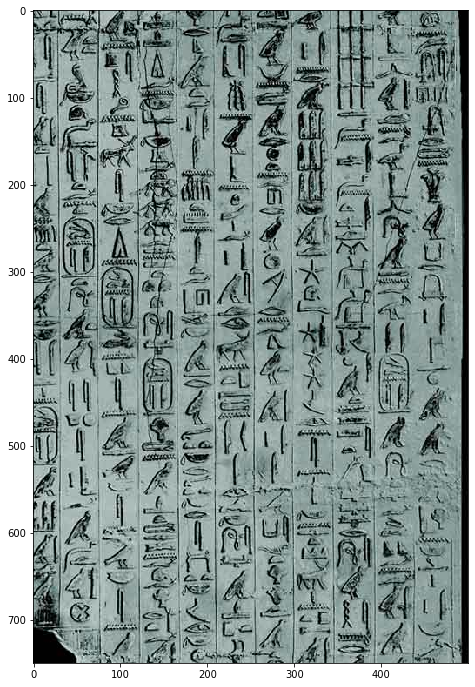

In [92]:
# Orig Image Shape (1507, 1720, 3)
img = cv2.imread('/Users/scott/sync/Sync/hieroglyphs/Texts/Test_Image/Antewest.jpg')[250:1000, 1220:]
print(img.shape)
plt.figure(figsize=(12,12))
plt.imshow(img)


In [99]:
heat_map = []
window_height = 40
window_width = 40
for y_step in range(0, img.shape[0], 5):
    for x_step in range(0, img.shape[1], 5):
        print((x_step, y_step))
        # Get window_width x window_height image segement
        crop_img = img[y_step:y_step+window_height, x_step:x_step+window_width].copy()
        # Get the heat value of the image segemnt
        heat = get_heat_value(crop_img, model, labels)
        # Appened heat value to heat map
        heat_map.append(heat)

(0, 0)
(5, 0)
(10, 0)
(15, 0)
(20, 0)
(25, 0)
(30, 0)
(35, 0)
(40, 0)
(45, 0)
(50, 0)
(55, 0)
(60, 0)
(65, 0)
(70, 0)
(75, 0)
(80, 0)
(85, 0)
(90, 0)
(95, 0)
(100, 0)
(105, 0)
(110, 0)
(115, 0)
(120, 0)
(125, 0)
(130, 0)
(135, 0)
(140, 0)
(145, 0)
(150, 0)
(155, 0)
(160, 0)
(165, 0)
(170, 0)
(175, 0)
(180, 0)
(185, 0)
(190, 0)
(195, 0)
(200, 0)
(205, 0)
(210, 0)
(215, 0)
(220, 0)
(225, 0)
(230, 0)
(235, 0)
(240, 0)
(245, 0)
(250, 0)
(255, 0)
(260, 0)
(265, 0)
(270, 0)
(275, 0)
(280, 0)
(285, 0)
(290, 0)
(295, 0)
(300, 0)
(305, 0)
(310, 0)
(315, 0)
(320, 0)
(325, 0)
(330, 0)
(335, 0)
(340, 0)
(345, 0)
(350, 0)
(355, 0)
(360, 0)
(365, 0)
(370, 0)
(375, 0)
(380, 0)
(385, 0)
(390, 0)
(395, 0)
(400, 0)
(405, 0)
(410, 0)
(415, 0)
(420, 0)
(425, 0)
(430, 0)
(435, 0)
(440, 0)
(445, 0)
(450, 0)
(455, 0)
(460, 0)
(465, 0)
(470, 0)
(475, 0)
(480, 0)
(485, 0)
(490, 0)
(495, 0)
(0, 5)
(5, 5)
(10, 5)
(15, 5)
(20, 5)
(25, 5)
(30, 5)
(35, 5)
(40, 5)
(45, 5)
(50, 5)
(55, 5)
(60, 5)
(65, 5)
(70, 5)
(75,

(300, 40)
(305, 40)
(310, 40)
(315, 40)
(320, 40)
(325, 40)
(330, 40)
(335, 40)
(340, 40)
(345, 40)
(350, 40)
(355, 40)
(360, 40)
(365, 40)
(370, 40)
(375, 40)
(380, 40)
(385, 40)
(390, 40)
(395, 40)
(400, 40)
(405, 40)
(410, 40)
(415, 40)
(420, 40)
(425, 40)
(430, 40)
(435, 40)
(440, 40)
(445, 40)
(450, 40)
(455, 40)
(460, 40)
(465, 40)
(470, 40)
(475, 40)
(480, 40)
(485, 40)
(490, 40)
(495, 40)
(0, 45)
(5, 45)
(10, 45)
(15, 45)
(20, 45)
(25, 45)
(30, 45)
(35, 45)
(40, 45)
(45, 45)
(50, 45)
(55, 45)
(60, 45)
(65, 45)
(70, 45)
(75, 45)
(80, 45)
(85, 45)
(90, 45)
(95, 45)
(100, 45)
(105, 45)
(110, 45)
(115, 45)
(120, 45)
(125, 45)
(130, 45)
(135, 45)
(140, 45)
(145, 45)
(150, 45)
(155, 45)
(160, 45)
(165, 45)
(170, 45)
(175, 45)
(180, 45)
(185, 45)
(190, 45)
(195, 45)
(200, 45)
(205, 45)
(210, 45)
(215, 45)
(220, 45)
(225, 45)
(230, 45)
(235, 45)
(240, 45)
(245, 45)
(250, 45)
(255, 45)
(260, 45)
(265, 45)
(270, 45)
(275, 45)
(280, 45)
(285, 45)
(290, 45)
(295, 45)
(300, 45)
(305, 45)
(3

(485, 80)
(490, 80)
(495, 80)
(0, 85)
(5, 85)
(10, 85)
(15, 85)
(20, 85)
(25, 85)
(30, 85)
(35, 85)
(40, 85)
(45, 85)
(50, 85)
(55, 85)
(60, 85)
(65, 85)
(70, 85)
(75, 85)
(80, 85)
(85, 85)
(90, 85)
(95, 85)
(100, 85)
(105, 85)
(110, 85)
(115, 85)
(120, 85)
(125, 85)
(130, 85)
(135, 85)
(140, 85)
(145, 85)
(150, 85)
(155, 85)
(160, 85)
(165, 85)
(170, 85)
(175, 85)
(180, 85)
(185, 85)
(190, 85)
(195, 85)
(200, 85)
(205, 85)
(210, 85)
(215, 85)
(220, 85)
(225, 85)
(230, 85)
(235, 85)
(240, 85)
(245, 85)
(250, 85)
(255, 85)
(260, 85)
(265, 85)
(270, 85)
(275, 85)
(280, 85)
(285, 85)
(290, 85)
(295, 85)
(300, 85)
(305, 85)
(310, 85)
(315, 85)
(320, 85)
(325, 85)
(330, 85)
(335, 85)
(340, 85)
(345, 85)
(350, 85)
(355, 85)
(360, 85)
(365, 85)
(370, 85)
(375, 85)
(380, 85)
(385, 85)
(390, 85)
(395, 85)
(400, 85)
(405, 85)
(410, 85)
(415, 85)
(420, 85)
(425, 85)
(430, 85)
(435, 85)
(440, 85)
(445, 85)
(450, 85)
(455, 85)
(460, 85)
(465, 85)
(470, 85)
(475, 85)
(480, 85)
(485, 85)
(490, 85)
(4

(430, 120)
(435, 120)
(440, 120)
(445, 120)
(450, 120)
(455, 120)
(460, 120)
(465, 120)
(470, 120)
(475, 120)
(480, 120)
(485, 120)
(490, 120)
(495, 120)
(0, 125)
(5, 125)
(10, 125)
(15, 125)
(20, 125)
(25, 125)
(30, 125)
(35, 125)
(40, 125)
(45, 125)
(50, 125)
(55, 125)
(60, 125)
(65, 125)
(70, 125)
(75, 125)
(80, 125)
(85, 125)
(90, 125)
(95, 125)
(100, 125)
(105, 125)
(110, 125)
(115, 125)
(120, 125)
(125, 125)
(130, 125)
(135, 125)
(140, 125)
(145, 125)
(150, 125)
(155, 125)
(160, 125)
(165, 125)
(170, 125)
(175, 125)
(180, 125)
(185, 125)
(190, 125)
(195, 125)
(200, 125)
(205, 125)
(210, 125)
(215, 125)
(220, 125)
(225, 125)
(230, 125)
(235, 125)
(240, 125)
(245, 125)
(250, 125)
(255, 125)
(260, 125)
(265, 125)
(270, 125)
(275, 125)
(280, 125)
(285, 125)
(290, 125)
(295, 125)
(300, 125)
(305, 125)
(310, 125)
(315, 125)
(320, 125)
(325, 125)
(330, 125)
(335, 125)
(340, 125)
(345, 125)
(350, 125)
(355, 125)
(360, 125)
(365, 125)
(370, 125)
(375, 125)
(380, 125)
(385, 125)
(390, 125)

(235, 160)
(240, 160)
(245, 160)
(250, 160)
(255, 160)
(260, 160)
(265, 160)
(270, 160)
(275, 160)
(280, 160)
(285, 160)
(290, 160)
(295, 160)
(300, 160)
(305, 160)
(310, 160)
(315, 160)
(320, 160)
(325, 160)
(330, 160)
(335, 160)
(340, 160)
(345, 160)
(350, 160)
(355, 160)
(360, 160)
(365, 160)
(370, 160)
(375, 160)
(380, 160)
(385, 160)
(390, 160)
(395, 160)
(400, 160)
(405, 160)
(410, 160)
(415, 160)
(420, 160)
(425, 160)
(430, 160)
(435, 160)
(440, 160)
(445, 160)
(450, 160)
(455, 160)
(460, 160)
(465, 160)
(470, 160)
(475, 160)
(480, 160)
(485, 160)
(490, 160)
(495, 160)
(0, 165)
(5, 165)
(10, 165)
(15, 165)
(20, 165)
(25, 165)
(30, 165)
(35, 165)
(40, 165)
(45, 165)
(50, 165)
(55, 165)
(60, 165)
(65, 165)
(70, 165)
(75, 165)
(80, 165)
(85, 165)
(90, 165)
(95, 165)
(100, 165)
(105, 165)
(110, 165)
(115, 165)
(120, 165)
(125, 165)
(130, 165)
(135, 165)
(140, 165)
(145, 165)
(150, 165)
(155, 165)
(160, 165)
(165, 165)
(170, 165)
(175, 165)
(180, 165)
(185, 165)
(190, 165)
(195, 165)

(35, 200)
(40, 200)
(45, 200)
(50, 200)
(55, 200)
(60, 200)
(65, 200)
(70, 200)
(75, 200)
(80, 200)
(85, 200)
(90, 200)
(95, 200)
(100, 200)
(105, 200)
(110, 200)
(115, 200)
(120, 200)
(125, 200)
(130, 200)
(135, 200)
(140, 200)
(145, 200)
(150, 200)
(155, 200)
(160, 200)
(165, 200)
(170, 200)
(175, 200)
(180, 200)
(185, 200)
(190, 200)
(195, 200)
(200, 200)
(205, 200)
(210, 200)
(215, 200)
(220, 200)
(225, 200)
(230, 200)
(235, 200)
(240, 200)
(245, 200)
(250, 200)
(255, 200)
(260, 200)
(265, 200)
(270, 200)
(275, 200)
(280, 200)
(285, 200)
(290, 200)
(295, 200)
(300, 200)
(305, 200)
(310, 200)
(315, 200)
(320, 200)
(325, 200)
(330, 200)
(335, 200)
(340, 200)
(345, 200)
(350, 200)
(355, 200)
(360, 200)
(365, 200)
(370, 200)
(375, 200)
(380, 200)
(385, 200)
(390, 200)
(395, 200)
(400, 200)
(405, 200)
(410, 200)
(415, 200)
(420, 200)
(425, 200)
(430, 200)
(435, 200)
(440, 200)
(445, 200)
(450, 200)
(455, 200)
(460, 200)
(465, 200)
(470, 200)
(475, 200)
(480, 200)
(485, 200)
(490, 200)
(

(335, 235)
(340, 235)
(345, 235)
(350, 235)
(355, 235)
(360, 235)
(365, 235)
(370, 235)
(375, 235)
(380, 235)
(385, 235)
(390, 235)
(395, 235)
(400, 235)
(405, 235)
(410, 235)
(415, 235)
(420, 235)
(425, 235)
(430, 235)
(435, 235)
(440, 235)
(445, 235)
(450, 235)
(455, 235)
(460, 235)
(465, 235)
(470, 235)
(475, 235)
(480, 235)
(485, 235)
(490, 235)
(495, 235)
(0, 240)
(5, 240)
(10, 240)
(15, 240)
(20, 240)
(25, 240)
(30, 240)
(35, 240)
(40, 240)
(45, 240)
(50, 240)
(55, 240)
(60, 240)
(65, 240)
(70, 240)
(75, 240)
(80, 240)
(85, 240)
(90, 240)
(95, 240)
(100, 240)
(105, 240)
(110, 240)
(115, 240)
(120, 240)
(125, 240)
(130, 240)
(135, 240)
(140, 240)
(145, 240)
(150, 240)
(155, 240)
(160, 240)
(165, 240)
(170, 240)
(175, 240)
(180, 240)
(185, 240)
(190, 240)
(195, 240)
(200, 240)
(205, 240)
(210, 240)
(215, 240)
(220, 240)
(225, 240)
(230, 240)
(235, 240)
(240, 240)
(245, 240)
(250, 240)
(255, 240)
(260, 240)
(265, 240)
(270, 240)
(275, 240)
(280, 240)
(285, 240)
(290, 240)
(295, 240)

(140, 275)
(145, 275)
(150, 275)
(155, 275)
(160, 275)
(165, 275)
(170, 275)
(175, 275)
(180, 275)
(185, 275)
(190, 275)
(195, 275)
(200, 275)
(205, 275)
(210, 275)
(215, 275)
(220, 275)
(225, 275)
(230, 275)
(235, 275)
(240, 275)
(245, 275)
(250, 275)
(255, 275)
(260, 275)
(265, 275)
(270, 275)
(275, 275)
(280, 275)
(285, 275)
(290, 275)
(295, 275)
(300, 275)
(305, 275)
(310, 275)
(315, 275)
(320, 275)
(325, 275)
(330, 275)
(335, 275)
(340, 275)
(345, 275)
(350, 275)
(355, 275)
(360, 275)
(365, 275)
(370, 275)
(375, 275)
(380, 275)
(385, 275)
(390, 275)
(395, 275)
(400, 275)
(405, 275)
(410, 275)
(415, 275)
(420, 275)
(425, 275)
(430, 275)
(435, 275)
(440, 275)
(445, 275)
(450, 275)
(455, 275)
(460, 275)
(465, 275)
(470, 275)
(475, 275)
(480, 275)
(485, 275)
(490, 275)
(495, 275)
(0, 280)
(5, 280)
(10, 280)
(15, 280)
(20, 280)
(25, 280)
(30, 280)
(35, 280)
(40, 280)
(45, 280)
(50, 280)
(55, 280)
(60, 280)
(65, 280)
(70, 280)
(75, 280)
(80, 280)
(85, 280)
(90, 280)
(95, 280)
(100, 280)

(435, 310)
(440, 310)
(445, 310)
(450, 310)
(455, 310)
(460, 310)
(465, 310)
(470, 310)
(475, 310)
(480, 310)
(485, 310)
(490, 310)
(495, 310)
(0, 315)
(5, 315)
(10, 315)
(15, 315)
(20, 315)
(25, 315)
(30, 315)
(35, 315)
(40, 315)
(45, 315)
(50, 315)
(55, 315)
(60, 315)
(65, 315)
(70, 315)
(75, 315)
(80, 315)
(85, 315)
(90, 315)
(95, 315)
(100, 315)
(105, 315)
(110, 315)
(115, 315)
(120, 315)
(125, 315)
(130, 315)
(135, 315)
(140, 315)
(145, 315)
(150, 315)
(155, 315)
(160, 315)
(165, 315)
(170, 315)
(175, 315)
(180, 315)
(185, 315)
(190, 315)
(195, 315)
(200, 315)
(205, 315)
(210, 315)
(215, 315)
(220, 315)
(225, 315)
(230, 315)
(235, 315)
(240, 315)
(245, 315)
(250, 315)
(255, 315)
(260, 315)
(265, 315)
(270, 315)
(275, 315)
(280, 315)
(285, 315)
(290, 315)
(295, 315)
(300, 315)
(305, 315)
(310, 315)
(315, 315)
(320, 315)
(325, 315)
(330, 315)
(335, 315)
(340, 315)
(345, 315)
(350, 315)
(355, 315)
(360, 315)
(365, 315)
(370, 315)
(375, 315)
(380, 315)
(385, 315)
(390, 315)
(395, 315)

(240, 350)
(245, 350)
(250, 350)
(255, 350)
(260, 350)
(265, 350)
(270, 350)
(275, 350)
(280, 350)
(285, 350)
(290, 350)
(295, 350)
(300, 350)
(305, 350)
(310, 350)
(315, 350)
(320, 350)
(325, 350)
(330, 350)
(335, 350)
(340, 350)
(345, 350)
(350, 350)
(355, 350)
(360, 350)
(365, 350)
(370, 350)
(375, 350)
(380, 350)
(385, 350)
(390, 350)
(395, 350)
(400, 350)
(405, 350)
(410, 350)
(415, 350)
(420, 350)
(425, 350)
(430, 350)
(435, 350)
(440, 350)
(445, 350)
(450, 350)
(455, 350)
(460, 350)
(465, 350)
(470, 350)
(475, 350)
(480, 350)
(485, 350)
(490, 350)
(495, 350)
(0, 355)
(5, 355)
(10, 355)
(15, 355)
(20, 355)
(25, 355)
(30, 355)
(35, 355)
(40, 355)
(45, 355)
(50, 355)
(55, 355)
(60, 355)
(65, 355)
(70, 355)
(75, 355)
(80, 355)
(85, 355)
(90, 355)
(95, 355)
(100, 355)
(105, 355)
(110, 355)
(115, 355)
(120, 355)
(125, 355)
(130, 355)
(135, 355)
(140, 355)
(145, 355)
(150, 355)
(155, 355)
(160, 355)
(165, 355)
(170, 355)
(175, 355)
(180, 355)
(185, 355)
(190, 355)
(195, 355)
(200, 355)

(40, 390)
(45, 390)
(50, 390)
(55, 390)
(60, 390)
(65, 390)
(70, 390)
(75, 390)
(80, 390)
(85, 390)
(90, 390)
(95, 390)
(100, 390)
(105, 390)
(110, 390)
(115, 390)
(120, 390)
(125, 390)
(130, 390)
(135, 390)
(140, 390)
(145, 390)
(150, 390)
(155, 390)
(160, 390)
(165, 390)
(170, 390)
(175, 390)
(180, 390)
(185, 390)
(190, 390)
(195, 390)
(200, 390)
(205, 390)
(210, 390)
(215, 390)
(220, 390)
(225, 390)
(230, 390)
(235, 390)
(240, 390)
(245, 390)
(250, 390)
(255, 390)
(260, 390)
(265, 390)
(270, 390)
(275, 390)
(280, 390)
(285, 390)
(290, 390)
(295, 390)
(300, 390)
(305, 390)
(310, 390)
(315, 390)
(320, 390)
(325, 390)
(330, 390)
(335, 390)
(340, 390)
(345, 390)
(350, 390)
(355, 390)
(360, 390)
(365, 390)
(370, 390)
(375, 390)
(380, 390)
(385, 390)
(390, 390)
(395, 390)
(400, 390)
(405, 390)
(410, 390)
(415, 390)
(420, 390)
(425, 390)
(430, 390)
(435, 390)
(440, 390)
(445, 390)
(450, 390)
(455, 390)
(460, 390)
(465, 390)
(470, 390)
(475, 390)
(480, 390)
(485, 390)
(490, 390)
(495, 390)


(340, 425)
(345, 425)
(350, 425)
(355, 425)
(360, 425)
(365, 425)
(370, 425)
(375, 425)
(380, 425)
(385, 425)
(390, 425)
(395, 425)
(400, 425)
(405, 425)
(410, 425)
(415, 425)
(420, 425)
(425, 425)
(430, 425)
(435, 425)
(440, 425)
(445, 425)
(450, 425)
(455, 425)
(460, 425)
(465, 425)
(470, 425)
(475, 425)
(480, 425)
(485, 425)
(490, 425)
(495, 425)
(0, 430)
(5, 430)
(10, 430)
(15, 430)
(20, 430)
(25, 430)
(30, 430)
(35, 430)
(40, 430)
(45, 430)
(50, 430)
(55, 430)
(60, 430)
(65, 430)
(70, 430)
(75, 430)
(80, 430)
(85, 430)
(90, 430)
(95, 430)
(100, 430)
(105, 430)
(110, 430)
(115, 430)
(120, 430)
(125, 430)
(130, 430)
(135, 430)
(140, 430)
(145, 430)
(150, 430)
(155, 430)
(160, 430)
(165, 430)
(170, 430)
(175, 430)
(180, 430)
(185, 430)
(190, 430)
(195, 430)
(200, 430)
(205, 430)
(210, 430)
(215, 430)
(220, 430)
(225, 430)
(230, 430)
(235, 430)
(240, 430)
(245, 430)
(250, 430)
(255, 430)
(260, 430)
(265, 430)
(270, 430)
(275, 430)
(280, 430)
(285, 430)
(290, 430)
(295, 430)
(300, 430)

(145, 465)
(150, 465)
(155, 465)
(160, 465)
(165, 465)
(170, 465)
(175, 465)
(180, 465)
(185, 465)
(190, 465)
(195, 465)
(200, 465)
(205, 465)
(210, 465)
(215, 465)
(220, 465)
(225, 465)
(230, 465)
(235, 465)
(240, 465)
(245, 465)
(250, 465)
(255, 465)
(260, 465)
(265, 465)
(270, 465)
(275, 465)
(280, 465)
(285, 465)
(290, 465)
(295, 465)
(300, 465)
(305, 465)
(310, 465)
(315, 465)
(320, 465)
(325, 465)
(330, 465)
(335, 465)
(340, 465)
(345, 465)
(350, 465)
(355, 465)
(360, 465)
(365, 465)
(370, 465)
(375, 465)
(380, 465)
(385, 465)
(390, 465)
(395, 465)
(400, 465)
(405, 465)
(410, 465)
(415, 465)
(420, 465)
(425, 465)
(430, 465)
(435, 465)
(440, 465)
(445, 465)
(450, 465)
(455, 465)
(460, 465)
(465, 465)
(470, 465)
(475, 465)
(480, 465)
(485, 465)
(490, 465)
(495, 465)
(0, 470)
(5, 470)
(10, 470)
(15, 470)
(20, 470)
(25, 470)
(30, 470)
(35, 470)
(40, 470)
(45, 470)
(50, 470)
(55, 470)
(60, 470)
(65, 470)
(70, 470)
(75, 470)
(80, 470)
(85, 470)
(90, 470)
(95, 470)
(100, 470)
(105, 470)

(440, 500)
(445, 500)
(450, 500)
(455, 500)
(460, 500)
(465, 500)
(470, 500)
(475, 500)
(480, 500)
(485, 500)
(490, 500)
(495, 500)
(0, 505)
(5, 505)
(10, 505)
(15, 505)
(20, 505)
(25, 505)
(30, 505)
(35, 505)
(40, 505)
(45, 505)
(50, 505)
(55, 505)
(60, 505)
(65, 505)
(70, 505)
(75, 505)
(80, 505)
(85, 505)
(90, 505)
(95, 505)
(100, 505)
(105, 505)
(110, 505)
(115, 505)
(120, 505)
(125, 505)
(130, 505)
(135, 505)
(140, 505)
(145, 505)
(150, 505)
(155, 505)
(160, 505)
(165, 505)
(170, 505)
(175, 505)
(180, 505)
(185, 505)
(190, 505)
(195, 505)
(200, 505)
(205, 505)
(210, 505)
(215, 505)
(220, 505)
(225, 505)
(230, 505)
(235, 505)
(240, 505)
(245, 505)
(250, 505)
(255, 505)
(260, 505)
(265, 505)
(270, 505)
(275, 505)
(280, 505)
(285, 505)
(290, 505)
(295, 505)
(300, 505)
(305, 505)
(310, 505)
(315, 505)
(320, 505)
(325, 505)
(330, 505)
(335, 505)
(340, 505)
(345, 505)
(350, 505)
(355, 505)
(360, 505)
(365, 505)
(370, 505)
(375, 505)
(380, 505)
(385, 505)
(390, 505)
(395, 505)
(400, 505)

(245, 540)
(250, 540)
(255, 540)
(260, 540)
(265, 540)
(270, 540)
(275, 540)
(280, 540)
(285, 540)
(290, 540)
(295, 540)
(300, 540)
(305, 540)
(310, 540)
(315, 540)
(320, 540)
(325, 540)
(330, 540)
(335, 540)
(340, 540)
(345, 540)
(350, 540)
(355, 540)
(360, 540)
(365, 540)
(370, 540)
(375, 540)
(380, 540)
(385, 540)
(390, 540)
(395, 540)
(400, 540)
(405, 540)
(410, 540)
(415, 540)
(420, 540)
(425, 540)
(430, 540)
(435, 540)
(440, 540)
(445, 540)
(450, 540)
(455, 540)
(460, 540)
(465, 540)
(470, 540)
(475, 540)
(480, 540)
(485, 540)
(490, 540)
(495, 540)
(0, 545)
(5, 545)
(10, 545)
(15, 545)
(20, 545)
(25, 545)
(30, 545)
(35, 545)
(40, 545)
(45, 545)
(50, 545)
(55, 545)
(60, 545)
(65, 545)
(70, 545)
(75, 545)
(80, 545)
(85, 545)
(90, 545)
(95, 545)
(100, 545)
(105, 545)
(110, 545)
(115, 545)
(120, 545)
(125, 545)
(130, 545)
(135, 545)
(140, 545)
(145, 545)
(150, 545)
(155, 545)
(160, 545)
(165, 545)
(170, 545)
(175, 545)
(180, 545)
(185, 545)
(190, 545)
(195, 545)
(200, 545)
(205, 545)

(45, 580)
(50, 580)
(55, 580)
(60, 580)
(65, 580)
(70, 580)
(75, 580)
(80, 580)
(85, 580)
(90, 580)
(95, 580)
(100, 580)
(105, 580)
(110, 580)
(115, 580)
(120, 580)
(125, 580)
(130, 580)
(135, 580)
(140, 580)
(145, 580)
(150, 580)
(155, 580)
(160, 580)
(165, 580)
(170, 580)
(175, 580)
(180, 580)
(185, 580)
(190, 580)
(195, 580)
(200, 580)
(205, 580)
(210, 580)
(215, 580)
(220, 580)
(225, 580)
(230, 580)
(235, 580)
(240, 580)
(245, 580)
(250, 580)
(255, 580)
(260, 580)
(265, 580)
(270, 580)
(275, 580)
(280, 580)
(285, 580)
(290, 580)
(295, 580)
(300, 580)
(305, 580)
(310, 580)
(315, 580)
(320, 580)
(325, 580)
(330, 580)
(335, 580)
(340, 580)
(345, 580)
(350, 580)
(355, 580)
(360, 580)
(365, 580)
(370, 580)
(375, 580)
(380, 580)
(385, 580)
(390, 580)
(395, 580)
(400, 580)
(405, 580)
(410, 580)
(415, 580)
(420, 580)
(425, 580)
(430, 580)
(435, 580)
(440, 580)
(445, 580)
(450, 580)
(455, 580)
(460, 580)
(465, 580)
(470, 580)
(475, 580)
(480, 580)
(485, 580)
(490, 580)
(495, 580)
(0, 585)
(

(345, 615)
(350, 615)
(355, 615)
(360, 615)
(365, 615)
(370, 615)
(375, 615)
(380, 615)
(385, 615)
(390, 615)
(395, 615)
(400, 615)
(405, 615)
(410, 615)
(415, 615)
(420, 615)
(425, 615)
(430, 615)
(435, 615)
(440, 615)
(445, 615)
(450, 615)
(455, 615)
(460, 615)
(465, 615)
(470, 615)
(475, 615)
(480, 615)
(485, 615)
(490, 615)
(495, 615)
(0, 620)
(5, 620)
(10, 620)
(15, 620)
(20, 620)
(25, 620)
(30, 620)
(35, 620)
(40, 620)
(45, 620)
(50, 620)
(55, 620)
(60, 620)
(65, 620)
(70, 620)
(75, 620)
(80, 620)
(85, 620)
(90, 620)
(95, 620)
(100, 620)
(105, 620)
(110, 620)
(115, 620)
(120, 620)
(125, 620)
(130, 620)
(135, 620)
(140, 620)
(145, 620)
(150, 620)
(155, 620)
(160, 620)
(165, 620)
(170, 620)
(175, 620)
(180, 620)
(185, 620)
(190, 620)
(195, 620)
(200, 620)
(205, 620)
(210, 620)
(215, 620)
(220, 620)
(225, 620)
(230, 620)
(235, 620)
(240, 620)
(245, 620)
(250, 620)
(255, 620)
(260, 620)
(265, 620)
(270, 620)
(275, 620)
(280, 620)
(285, 620)
(290, 620)
(295, 620)
(300, 620)
(305, 620)

(150, 655)
(155, 655)
(160, 655)
(165, 655)
(170, 655)
(175, 655)
(180, 655)
(185, 655)
(190, 655)
(195, 655)
(200, 655)
(205, 655)
(210, 655)
(215, 655)
(220, 655)
(225, 655)
(230, 655)
(235, 655)
(240, 655)
(245, 655)
(250, 655)
(255, 655)
(260, 655)
(265, 655)
(270, 655)
(275, 655)
(280, 655)
(285, 655)
(290, 655)
(295, 655)
(300, 655)
(305, 655)
(310, 655)
(315, 655)
(320, 655)
(325, 655)
(330, 655)
(335, 655)
(340, 655)
(345, 655)
(350, 655)
(355, 655)
(360, 655)
(365, 655)
(370, 655)
(375, 655)
(380, 655)
(385, 655)
(390, 655)
(395, 655)
(400, 655)
(405, 655)
(410, 655)
(415, 655)
(420, 655)
(425, 655)
(430, 655)
(435, 655)
(440, 655)
(445, 655)
(450, 655)
(455, 655)
(460, 655)
(465, 655)
(470, 655)
(475, 655)
(480, 655)
(485, 655)
(490, 655)
(495, 655)
(0, 660)
(5, 660)
(10, 660)
(15, 660)
(20, 660)
(25, 660)
(30, 660)
(35, 660)
(40, 660)
(45, 660)
(50, 660)
(55, 660)
(60, 660)
(65, 660)
(70, 660)
(75, 660)
(80, 660)
(85, 660)
(90, 660)
(95, 660)
(100, 660)
(105, 660)
(110, 660)

(445, 690)
(450, 690)
(455, 690)
(460, 690)
(465, 690)
(470, 690)
(475, 690)
(480, 690)
(485, 690)
(490, 690)
(495, 690)
(0, 695)
(5, 695)
(10, 695)
(15, 695)
(20, 695)
(25, 695)
(30, 695)
(35, 695)
(40, 695)
(45, 695)
(50, 695)
(55, 695)
(60, 695)
(65, 695)
(70, 695)
(75, 695)
(80, 695)
(85, 695)
(90, 695)
(95, 695)
(100, 695)
(105, 695)
(110, 695)
(115, 695)
(120, 695)
(125, 695)
(130, 695)
(135, 695)
(140, 695)
(145, 695)
(150, 695)
(155, 695)
(160, 695)
(165, 695)
(170, 695)
(175, 695)
(180, 695)
(185, 695)
(190, 695)
(195, 695)
(200, 695)
(205, 695)
(210, 695)
(215, 695)
(220, 695)
(225, 695)
(230, 695)
(235, 695)
(240, 695)
(245, 695)
(250, 695)
(255, 695)
(260, 695)
(265, 695)
(270, 695)
(275, 695)
(280, 695)
(285, 695)
(290, 695)
(295, 695)
(300, 695)
(305, 695)
(310, 695)
(315, 695)
(320, 695)
(325, 695)
(330, 695)
(335, 695)
(340, 695)
(345, 695)
(350, 695)
(355, 695)
(360, 695)
(365, 695)
(370, 695)
(375, 695)
(380, 695)
(385, 695)
(390, 695)
(395, 695)
(400, 695)
(405, 695)

(250, 730)
(255, 730)
(260, 730)
(265, 730)
(270, 730)
(275, 730)
(280, 730)
(285, 730)
(290, 730)
(295, 730)
(300, 730)
(305, 730)
(310, 730)
(315, 730)
(320, 730)
(325, 730)
(330, 730)
(335, 730)
(340, 730)
(345, 730)
(350, 730)
(355, 730)
(360, 730)
(365, 730)
(370, 730)
(375, 730)
(380, 730)
(385, 730)
(390, 730)
(395, 730)
(400, 730)
(405, 730)
(410, 730)
(415, 730)
(420, 730)
(425, 730)
(430, 730)
(435, 730)
(440, 730)
(445, 730)
(450, 730)
(455, 730)
(460, 730)
(465, 730)
(470, 730)
(475, 730)
(480, 730)
(485, 730)
(490, 730)
(495, 730)
(0, 735)
(5, 735)
(10, 735)
(15, 735)
(20, 735)
(25, 735)
(30, 735)
(35, 735)
(40, 735)
(45, 735)
(50, 735)
(55, 735)
(60, 735)
(65, 735)
(70, 735)
(75, 735)
(80, 735)
(85, 735)
(90, 735)
(95, 735)
(100, 735)
(105, 735)
(110, 735)
(115, 735)
(120, 735)
(125, 735)
(130, 735)
(135, 735)
(140, 735)
(145, 735)
(150, 735)
(155, 735)
(160, 735)
(165, 735)
(170, 735)
(175, 735)
(180, 735)
(185, 735)
(190, 735)
(195, 735)
(200, 735)
(205, 735)
(210, 735)

In [102]:
import pickle
with open(os.path.expanduser('~/p5/data/heatmap.pkl'), 'wb') as f:
    pickle.dump(heat_map, f)

In [103]:
np_map = np.array(heat_map)


In [104]:
np_map.shape

(15000,)

In [105]:
len(range(0, img.shape[0], 5))

150

In [106]:
len(range(0, img.shape[1], 5))

100

In [116]:
np_map2 = np.reshape(np_map, (150, 100))

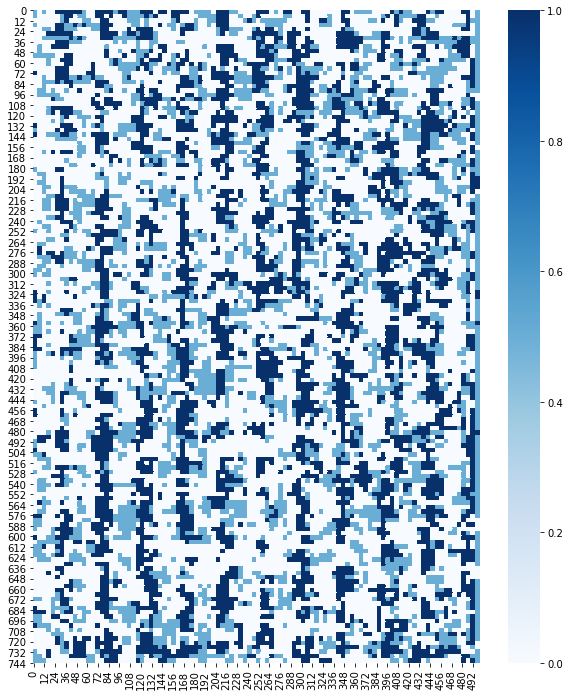

In [117]:
import seaborn as sns
plt.subplot
plt.figure(figsize=(10,12))
sns.heatmap(np.repeat(np.repeat(np_map2, 5, axis=0), 5, axis=1), cmap='Blues')
img2 = cv2.imread('/Users/scott/sync/Sync/hieroglyphs/Texts/Test_Image/Antewest.jpg')[250:1000, 1220:]
print(img2.shape)
plt.figure(figsize=(12,12))
plt.imshow(img)

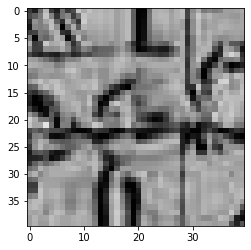

In [94]:
img_part = to_gray_scale(img[:40, :40])
plt.imshow(img_part)

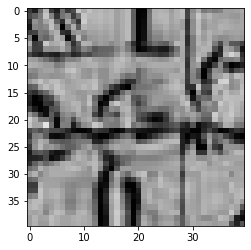

In [91]:

# labels[np.argmax(model.predict(np.expand_dims(cv2.resize(to_gray_scale(img[:40, :40]), (224, 224)), axis=0)))]

In [47]:
np.array(None)

array(None, dtype=object)

In [62]:
1720 / 4 * 3

1290.0

In [67]:
1507 / 6

251.16666666666666

In [ ]:
m17 = pred_df[pred_df['predicted'] == 'M17']

In [ ]:
m17.head()

In [ ]:
m17.filename[:5]

In [ ]:
import shutil
for image_file in ['/Users/scott/p5/data/interim/m17/' + name for name in m17.filename.sample(100)]:
    print(image_file)
    shutil.copy2(image_file, '/Users/scott/p5/data/interim/m17/positives')
    


In [ ]:
 # /Users/scott/p5/data/interim/m17

In [ ]:
model = load_model(os.path.expanduser('hieroglyphs_vgg19_M17_only.h5'))

In [ ]:
test_batches = ImageDataGenerator(preprocessing_function=to_gray_scale).flow_from_directory(os.path.expanduser('/Users/scott/p5/data/interim/m17'), 
                                                        target_size=(224,224),
                                                        shuffle=False,
                                                        batch_size=1)

In [ ]:
# model.predict()
# cv.im

### PLAY

In [ ]:
temp = np.random.randn(50,100)
# temp

In [ ]:
plt.imshow(temp,cmap = 'jet')
plt.colorbar()

In [ ]:
import cv2 


In [ ]:
!ls

In [ ]:
img = cv2.imread('SarcEastGH.jpg')  


In [ ]:
img.shape

In [ ]:
plt.figure(figsize=[10,10])
plt.imshow(img)

In [ ]:
temp = np.random.randn(1060,1720,3)


In [ ]:
plt.figure(figsize=[10,10])
plt.imshow(img+temp)